In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numpngw import write_apng
from IPython.display import Image
from pendulum import *
import mujoco
from lqr import *
from mppi_control import MPPIController, get_cartpole_mppi_hyperparams


  0%|          | 0/100 [00:00<?, ?it/s]

[ 0.         10.47197551  4.19873858  4.19873858]
[[4.0e+01 4.0e+01 4.0e+01]
 [2.0e-02 1.0e+00 0.0e+00]
 [1.0e-01 1.0e-01 0.0e+00]
 [4.5e-02 3.0e-01 0.0e+00]
 [4.5e-02 3.0e-01 0.0e+00]]
[[0.  0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0.3]
 [0.  0.  0.3]]
[[0.         0.         0.        ]
 [0.1267109  0.1267109  0.04817109]
 [0.15497067 0.15497067 0.00417393]
 [0.15497067 0.15497067 0.00417393]]
1
2
3
[0.05 0.05 0.05]
0.01
[ 1.00e-05  0.00e+00 -9.81e+00]
[[0.  0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0.6]]


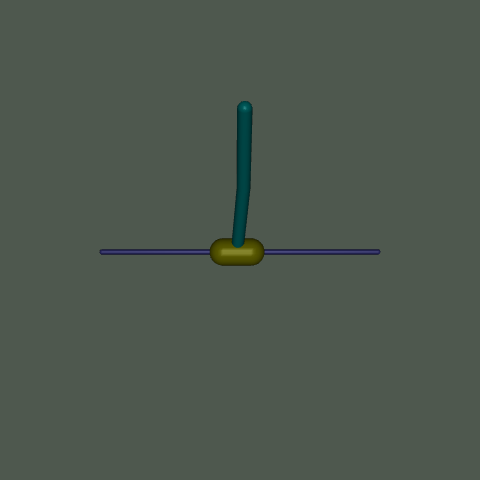

In [3]:
# Test environment
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
env.reset()

frames = []  # frames to create animated png
frames.append(env.render())
for i in tqdm(range(100)):
    action = env.action_space.sample()
    s = env.step(action)
    img = env.render()
    frames.append(img)

# Get properties of the pendulum
m = env.model.body_mass
l = env.model.geom_size
lcm = env.model.body_ipos
I = env.model.body_inertia
print(m)
print(l)
print(lcm)
print(I)

print(mujoco.mj_name2id(env.model, 1, 'cart'))
print(mujoco.mj_name2id(env.model, 1, 'pole'))
print(mujoco.mj_name2id(env.model, 1, 'pole2'))

print(env.model.dof_damping)
print(env.model.opt.timestep)
print(env.model.opt.gravity)
print(env.model.body_pos)

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")

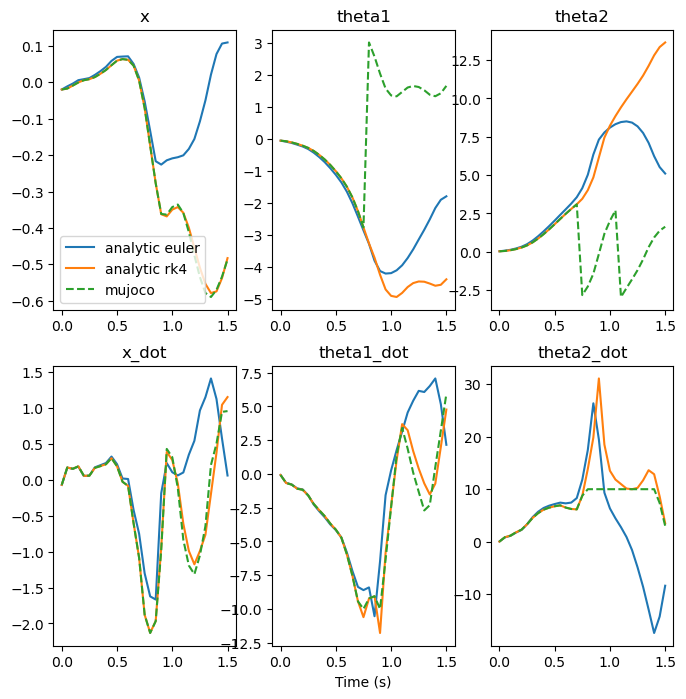

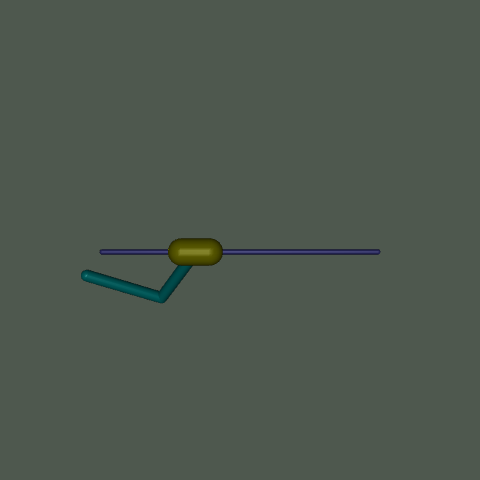

In [4]:
## Let's test to see if your analytic dynamics matches the simulator

frames = []  # frames to create animated png
frames.append(env.render())

# Total time steps
T = 30
dt = 0.05
tf = T*dt

# First let's generate a random control sequence
control_sequence = 0.1*np.random.randn(T, 1)

# We use the simulator to simulate a trajectory
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
start_state, _ = env.reset()

states_mujoco = np.zeros((T+1, 8))
states_mujoco[0] = start_state[:8]

for t in range(T):
    full_states_mujoco, _, _, _, _ = env.step(control_sequence[t])
    states_mujoco[t+1] = full_states_mujoco[:8]
    img = env.render()
    frames.append(img)

# Now we will use your analytic dynamics to simulate a trajectory
# Need an extra 1 which is the batch dimension (T x B x 4)
states_analytic_euler = torch.zeros((T+1, 1, 6))
states_analytic_euler[0] = change_of_coords(start_state)
states_analytic_rk4 = torch.zeros((T+1, 1, 6))
states_analytic_rk4[0] = change_of_coords(start_state)
for t in range(T):
    states_analytic_euler[t + 1] = dynamics_analytic(states_analytic_euler[t], torch.from_numpy(control_sequence[t]))
    states_analytic_rk4[t + 1] = dynamics_rk4(states_analytic_rk4[t], torch.from_numpy(control_sequence[t]))

# convert back to numpy for plotting
states_analytic_euler = states_analytic_euler.reshape(T+1, 6)
states_analytic_rk4 = states_analytic_rk4.reshape(T+1, 6)

# convert mujoco states to analytic states
states_mujoco_transformed = T_change_of_coords(states_mujoco)

# Plot and compare - They should be indistinguishable
fig, axes = plt.subplots(2, 3, figsize=(8, 8))

t_vec = np.linspace(0, tf, T+1)

axes[0][0].plot(t_vec, states_analytic_euler[:, 0], label='analytic euler')
axes[0][0].plot(t_vec, states_analytic_rk4[:, 0], label='analytic rk4')
axes[0][0].plot(t_vec, states_mujoco_transformed[:, 0], '--', label='mujoco')
axes[0][0].title.set_text('x')

axes[0][1].plot(t_vec, states_analytic_euler[:, 1])
axes[0][1].plot(t_vec, states_analytic_rk4[:, 1])
axes[0][1].plot(t_vec, states_mujoco_transformed[:, 1], '--')
axes[0][1].title.set_text('theta1')

axes[0][2].plot(t_vec, states_analytic_euler[:, 2])
axes[0][2].plot(t_vec, states_analytic_rk4[:, 2])
axes[0][2].plot(t_vec, states_mujoco_transformed[:, 2], '--')
axes[0][2].title.set_text('theta2')

axes[1][0].plot(t_vec, states_analytic_euler[:, 3])
axes[1][0].plot(t_vec, states_analytic_rk4[:, 3])
axes[1][0].plot(t_vec, states_mujoco_transformed[:, 3], '--')
axes[1][0].title.set_text('x_dot')

axes[1][1].plot(t_vec, states_analytic_euler[:, 4])
axes[1][1].plot(t_vec, states_analytic_rk4[:, 4])
axes[1][1].plot(t_vec, states_mujoco_transformed[:, 4], '--')
axes[1][1].title.set_text('theta1_dot')
axes[1][1].set_xlabel("Time (s)")

axes[1][2].plot(t_vec, states_analytic_euler[:, 5])
axes[1][2].plot(t_vec, states_analytic_rk4[:, 5])
axes[1][2].plot(t_vec, states_mujoco_transformed[:, 5], '--')
axes[1][2].title.set_text('theta2_dot')

axes[0][0].legend()
plt.show()

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")


In [5]:
# simulation parameters
Th = 0.8 # this refers to the time horizon for the optimization
dt = 0.05
N = int(Th/dt + 1)
num_lqr_iterations = 4
mu_min = 1e-6#10e-6
mu = mu_min
mu_delta_0 = 2
mu_delta = mu_delta_0
Tf = 3 #5 # total time running mpc
num_mpc_iterations = int(Tf/dt + 1)
# for backtracking line search
gamma = 0.5
alpha = 1.0
c = 1e-4 # inner loop cost tolerance
eps = 1e-6 # outer loop cost tolerance
alpha_min = 5e-2

# LQR parameters
# set the desired state (xstar), should be the goal state
# will will be linearizing about this point
xstar = torch.zeros((6,))
# set the Q and R matrices
# TODO: tune the Q, R amd Qf matrices
Q = torch.diag(torch.tensor([1.0, 5.0, 5.0, 1.0, 1.0, 1.0]))
R = torch.tensor([[0.5]])
#Q = torch.diag(torch.tensor([40.0, 10.0, 10.0, 1.0, 1.0, 1.0]))
#R = torch.tensor([[0.05]])
Qf = 1.0 * Q

In [6]:
def demo_ilqr(pos, vel, acc):
    env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
    start_state = set_state(env, pos, vel, acc)
    current_state = change_of_coords(start_state)
    #_, _, _, _, _ = env.step(np.array([0]))

    # store all of the actions over all the iterations of LQR
    actions = torch.zeros((num_mpc_iterations, 1))
    states = torch.zeros((num_mpc_iterations+1, 6))
    states[0, :] = current_state

    frames = []  # frames to create animated png
    frames.append(env.render())

    for i in tqdm(range(num_mpc_iterations)):
        
        # run the iLQR optimization
        us, _ = run_ilqr(current_state, N, Th, num_lqr_iterations, xstar,
                         mu, mu_delta_0, mu_delta, mu_min, Q, R, Qf, alpha, c, gamma, eps, alpha_min)
        # get the first control input value from the ilqr optimization
        action = us[0, :]

        # apply the action to move the simulation to the next state
        next_state, _, _, _, _ = env.step(action)
        next_state = change_of_coords(next_state)
        
        img = env.render()
        frames.append(img)
        # store all of the actions and the states that were taken
        actions[i, :] = action
        states[i+1, :] = next_state
        current_state = next_state

    return states, actions, frames

def plot_multiple_states(labels_list,states_list, actions_list):
    
    # plot the optimal state trajectory over time
    plt.figure()
    t_vec_x = np.linspace(0, Tf, num_mpc_iterations+1)
    fig, axs = plt.subplots(3, 1, sharex=True)

    for i in range(len(states_list)):
        lin0, = axs[0].plot(t_vec_x, states_list[i][:, 0], lw=2, label=labels_list[i])
        lin1, = axs[1].plot(t_vec_x, states_list[i][:, 1], lw=2)
        lin2, = axs[2].plot(t_vec_x, states_list[i][:, 2], lw=2)
    axs[0].set_title('Optimal state trajectories over time')
    axs[0].set_ylabel("x_cart (m)")
    axs[1].set_ylabel("Theta_1 (rad)")
    axs[2].set_ylabel("Theta_2 (rad)")
    axs[-1].set_xlabel("Time (s)")
    axs[0].legend()

    # plot the optimal state trajectory over time
    plt.figure()
    t_vec_x = np.linspace(0, Tf, num_mpc_iterations+1)
    fig, axs = plt.subplots(3, 1, sharex=True)

    for i in range(len(states_list)):
        lin0, = axs[0].plot(t_vec_x, states_list[i][:, 3], lw=2, label=labels_list[i])
        lin1, = axs[1].plot(t_vec_x, states_list[i][:, 4], lw=2)
        lin2, = axs[2].plot(t_vec_x, states_list[i][:, 5], lw=2)
    axs[0].set_ylabel("x_cart_dot (m/s)")
    axs[1].set_ylabel("Theta_1_dot (rad/s)")
    axs[2].set_ylabel("Theta_2_dot (rad/s)")
    axs[-1].set_xlabel("Time (s)")
    axs[0].legend()

    # plot the optimal control trajectory
    plt.figure()
    t_vec_u = np.linspace(0, Tf, num_mpc_iterations)
    for i in range(len(actions_list)):
        lin0, = plt.plot(t_vec_u, actions_list[i][:, 0], lw=1, label=labels_list[i])
    plt.title('Optimal control inputs over time')
    plt.ylabel("control inputs (N)")
    plt.xlabel("Time (s)")
    plt.legend()

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

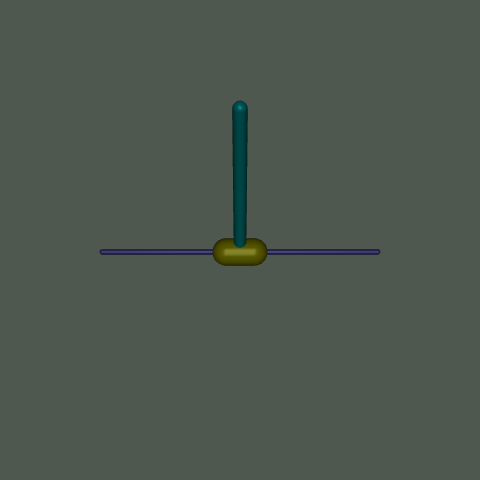

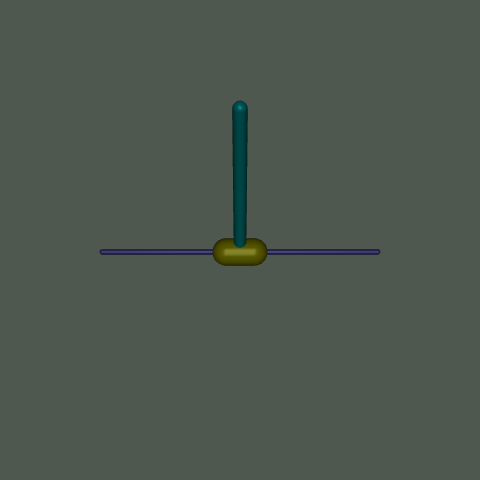

<Figure size 640x480 with 0 Axes>

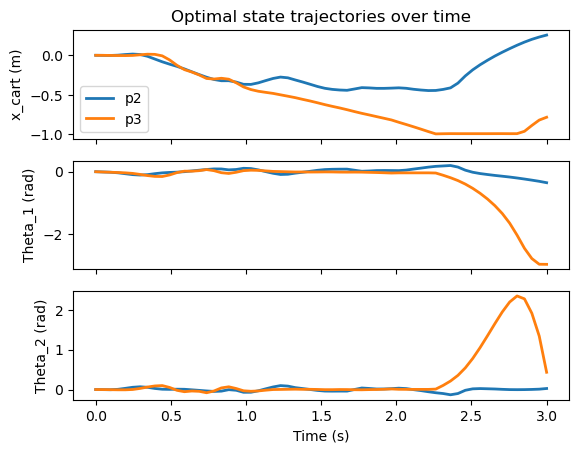

<Figure size 640x480 with 0 Axes>

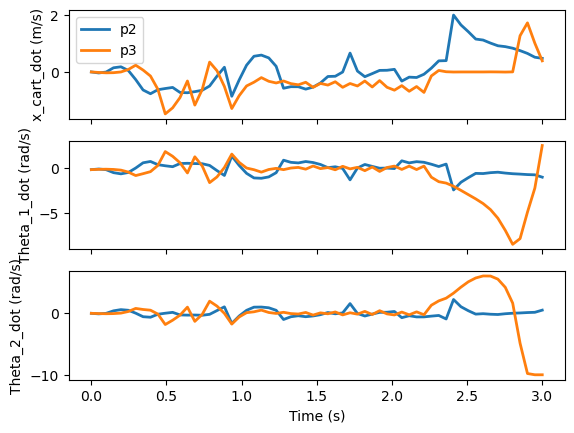

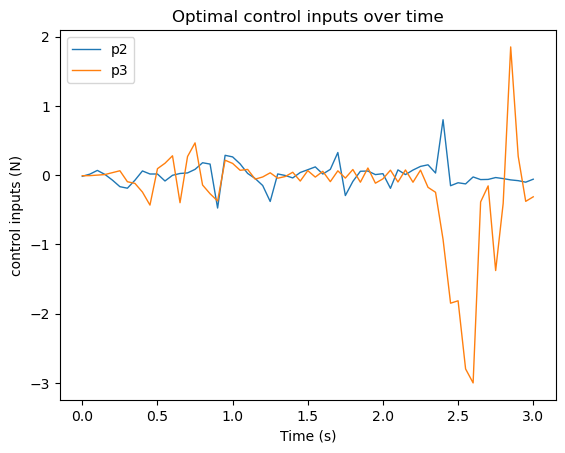

In [9]:
pos = [0, 0, 0]
vel = [0, -0.2, 0]
acc = [0, 0, 0]

# pos = [0, 0.1, -0.1]
# vel = [0, 0, 0]
# acc = [0, 0, 0]

# pos = [0, 0.2, 0]
# vel = [0, 0, 0]
# acc = [0, 0, 0]

# pos = [0, np.pi, 0]
# vel = [0, 0, 0]
# acc = [0, 0, 0]


# Th = 0.8
# N = int(Th/dt + 1)
# num_lqr_iterations = 4
# Q = torch.diag(torch.tensor([5.0, 10.0, 10.0, 1.0, 1.0, 1.0]))
# R = torch.tensor([[0.5]])
# Qf = 0.4 * Q

# Th = 0.6
# N = int(Th/dt + 1)
# num_lqr_iterations = 1
# Q = torch.diag(torch.tensor([50.0, 65.0, 65.0, 1.0, 26.0, 26.0]))
# R = torch.tensor([[1.0]])
# Qf = 25.0 * Q


# # simulation parameters
# Th = 1.4
# N = int(Th/dt + 1)
# num_lqr_iterations = 1
# Q = torch.diag(torch.tensor([20.0, 68.0, 68.0, 1.0, 30.0, 30.0]))
# R = torch.tensor([[0.5]])
# Qf = 4.0 * Q

# states1, actions1, frames1 = demo_ilqr(pos, vel, acc)

# simulation parameters
Th = 1.0
N = int(Th/dt + 1)
num_lqr_iterations = 1
Q = torch.diag(torch.tensor([50.0, 60.0, 60.0, 1.0, 18.0, 18.0]))
R = torch.tensor([[1.0]])
Qf = 5.5 * Q

states2, actions2, frames2 = demo_ilqr(pos, vel, acc)

# simulation parameters
Th = 0.9
N = int(Th/dt + 1)
num_lqr_iterations = 1
Q = torch.diag(torch.tensor([50.0, 65.0, 65.0, 1.0, 22.0, 22.0]))
R = torch.tensor([[1.0]])
Qf = 6.0 * Q

states3, actions3, frames3 = demo_ilqr(pos, vel, acc)


#write_apng("cartpole_example1.png", frames1, delay=5)
write_apng("cartpole_example2.png", frames2, delay=5)
write_apng("cartpole_example3.png", frames3, delay=5)
#display(Image(filename="cartpole_example1.png"))
display(Image(filename="cartpole_example2.png"))
display(Image(filename="cartpole_example3.png"))

#plot_multiple_states(["p1","p2","p3"],[states1, states2, states3], [actions1, actions2, actions3])
plot_multiple_states(["p2","p3"],[states2, states3], [ actions2, actions3])



  0%|          | 0/80 [00:00<?, ?it/s]

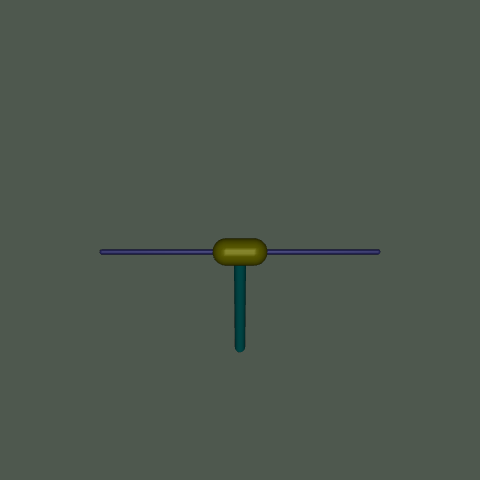

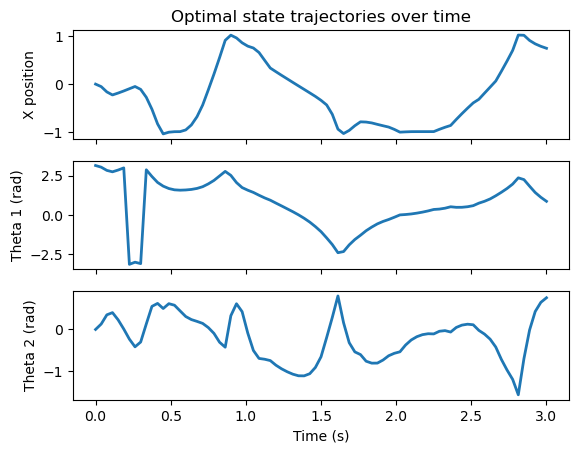

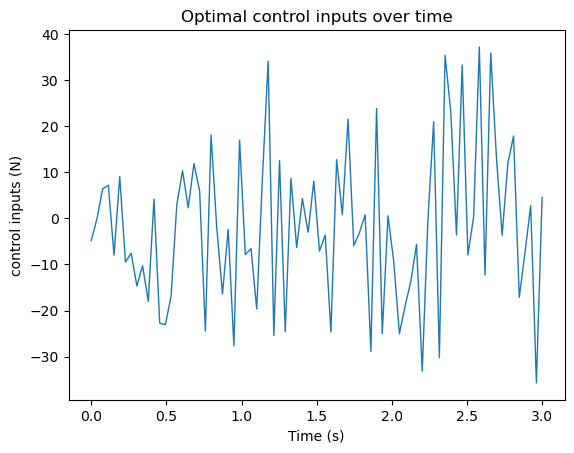

In [10]:
mpc_iter = 80

## run MPC on the simulated double inverted pendulum
# initialize the inverted pedulum object
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
# get the initial state of the simulation
# start_state,_ = env.reset()
pos = [0, np.pi, 0]
vel = [0, 0, 0]
acc = [0, 0, 0]
start_state = set_state(env, pos, vel, acc)
#init_state = start_state[:8].reshape(8,)
#current_state = change_of_coords(init_state)
current_state = change_of_coords(start_state)
_, _, _, _, _ = env.step(np.array([0]))

goal_state = np.zeros(6)
controller = MPPIController(env, num_samples=100, horizon=20, hyperparams=get_cartpole_mppi_hyperparams())
controller.goal_state = torch.tensor(goal_state, dtype=torch.float32)

# store all of the actions over all the iterations of MPPI
actions = torch.zeros((mpc_iter, 1))
states = torch.zeros((mpc_iter+1, 6))
states[0, :] = current_state

frames = []  # frames to create animated png
frames.append(env.render())

pbar = tqdm(range(mpc_iter))
for i in pbar:
    
    # get the first control input value from the MPPI optimization
    action = controller.command(current_state) # returns us[0,:]

    # apply the action to move the simulation to the next state
    next_state, _, _, _, _ = env.step(action)
    next_state = change_of_coords(next_state)
    error_i = np.linalg.norm(next_state-goal_state)
    pbar.set_description(f'Goal Error: {error_i:.4f}')
    img = env.render()
    frames.append(img)
    # store all of the actions and the states that were taken
    actions[i, :] = action
    states[i+1, :] = next_state
    current_state = next_state

    if error_i < .2:
        break

# plot the optimal state trajectory over time
t_vec_x = np.linspace(0, Tf, mpc_iter+1)
fig, axs = plt.subplots(3, 1, sharex=True)
lin0, = axs[0].plot(t_vec_x, states[:, 0], lw=2)
lin1, = axs[1].plot(t_vec_x, states[:, 1], lw=2)
lin2, = axs[2].plot(t_vec_x, states[:, 2], lw=2)
axs[0].set_title('Optimal state trajectories over time')
axs[0].set_ylabel("X position")
axs[1].set_ylabel("Theta 1 (rad)")
axs[2].set_ylabel("Theta 2 (rad)")
axs[-1].set_xlabel("Time (s)")

# plot the optimal control trajectory
plt.figure()
t_vec_u = np.linspace(0, Tf, mpc_iter)
lin0, = plt.plot(t_vec_u, actions[:, 0], lw=1)
plt.title('Optimal control inputs over time')
plt.ylabel("control inputs (N)")
plt.xlabel("Time (s)")

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")
